# plot ROC

In [3]:
import math
import json
import copy
import time
import numpy as np
import pandas as pd
from sl_1 import * # my custom module 
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [10]:
def function(a, b): # a: true target; b: predict
    arr1 = np.zeros(shape=(len(a),1))
    arr1[(b == 0) & (a == 0)] = 0 # TN
    arr1[(b == 1) & (a == 1)] = 1 # TP
    arr1[(b == 1) & (a == 0)] = 2 # FP
    arr1[(b == 0) & (a == 1)] = 3 # FN
    return arr1
# a = np.array([0,0,1,1])
# b = np.array([0,1,1,0])
# function(a, b)
def para_dict(clean_data, col_inx, node_num):
    '''input: clean_data, a cleaned dataset (no NA) used to predict the built area.
       input: col_inx, a columns index list of cleaned data used to predict urban built.
       input: node_num, a number of nodes of decison tree.
       output: the predicted result and parameter of decision tree.
    '''
    dict0 = {}
    x_features = clean_data.iloc[:,col_inx].columns
    y_col = 'Target'
    X_Train = Train[x_features].copy()
    X_Test = Test[x_features].copy()
    Y_Train = Train[[y_col]].copy()
    Y_Test = Test[[y_col]].copy() # 获取子 dataframe
    clf = DecisionTreeClassifier(max_leaf_nodes=node_num, random_state=1)
    clf.fit(X_Train, Y_Train)
    predictions = clf.predict(X_Test)
# test in test data
#     acc1 = accuracy_score(y_true = Y_Test, y_pred = predictions) # accuracy of test data
    
    tn, fp, fn, tp = confusion_matrix(y_true = Y_Test, y_pred = predictions).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2*precision*recall/(precision+recall)
    proba = clf.predict_proba(X_Test)
    log_proba = clf.predict_log_proba(X_Test)

# prediction
    x_data = clean_data[x_features].copy()
    y_data = clean_data[[y_col]].copy()
    pred_y = clf.predict(x_data)
# over_all accuracy
#     acc2 = accuracy_score(y_true = y_data, y_pred = pred_y)
#     overall_kappa = cohen_kappa_score(y_data, pred_y)
#     proba = clf.predict_proba(x_data)
#     log_proba = clf.predict_log_proba(x_data)

    data1 = clean_data.copy()
    ins_loc = len(clean_data.columns) # insert it to end
    data1.insert(ins_loc,'pred_y',pred_y)
    a = np.array(data1.Target)
    b = pred_y
    data1['pred_y1'] = function(a, b)
    
    if len(col_inx) <= 1:
        ASC_Name = clean_data.columns[col_inx][0]
    else:
        ASC_Name = '_'.join(clean_data.columns[col_inx])
### add to dictionary
    dict0['Name'] =  ASC_Name
    dict0['Precision'] = round(precision,6) # pre
    dict0['F1_score'] = round(f1_score,6) # pre
    dict0['Proba'] = proba
    dict0['Log_Proba'] = log_proba
    dict0['Recall'] = round(recall,6)
    dict0['Pred_y'] = pred_y
    dict0['Pred_y1'] = np.array(data1['pred_y1'])
#     dict0['Acc_Test'] = round(acc1,6)
#     dict0['Acc_All'] = round(acc2,6)
#     dict0['Kappa'] = round(overall_kappa,6)
#     dict0['Target'] = np.array(y_data).ravel() # overall
    dict0['Target'] = np.array(Y_Test).ravel()
    dict0['TN'] = tn
    dict0['FP'] = fp
    dict0['FN'] = fn
    dict0['TP'] = tp
    return dict0
# %%time
# 5.93 s
# para_0 = para_dict(clean_data, [1,2], 11)
# para_0

In [11]:
# %%time
# Wall time: 27.1 s
def para_dict_all(data, col_inx_list, node_num):
    '''input: col_inx, a list, a columns index list of cleaned data used to predict urban built.
       input: node_num, a number of nodes of decison tree.
       output: the predicted result and parameter of decision tree.
    '''
    dict1 = {}
    i = 0
    for col_inx in col_inx_list:
        para_0 = para_dict(data, col_inx, node_num)
        dict1[str(i)] = para_0
        i += 1
    return dict1
# para_DT = para_dict_all(clean_data, [[1],[2],[3],[1,2,3]], 11)
# para_DT

In [12]:
# %%time
# Wall time: 17.9 s
def pred_ASC(raw_data, clean_data, par_all, w_name, Bool=1):
    '''input:raw_data, a raw dataset (have NA) used to predict the built area.
       input:clean_data, a cleaned dataset (no NA) used to predict the built area.
       input:para_all, a dict, the predicted result and parameter of decision tree.
       input:w_name, the output file folder name.
       input:Bool, a bool value of '0' or '1', defult is 1; '0' means pred y have 
             value(0 and 1) while '1' means pred y have  value(0, 1, 2 and 3).
       output: print the pred_y to a ASCII file.
    '''
    print('程序开始运行')
    for key,value in para_all.items():
        if key != 'Target':
            name = value['Name']
            if Bool == 1:
                pred_y = value['Pred_y1']
            elif Bool == 0:
                pred_y = value['Pred_y']
            else:
                print('unexpected input variable of Bool. Bool are suposed to be a bool value of "0" or "1" ')
            data1 = clean_data.copy()
            data1['pred_y'] = pred_y
            data2 = pd.merge(raw_data, data1.iloc[:,[-2,-1]], how='left', left_on='ID', right_on='ID', sort=True)
            data3 = data2.copy().fillna(-9999)
            shape_ras = (1786, 1932) # 栅格行列数
            built_pre = np.array(data3['pred_y']).reshape(shape_ras)
            np.savetxt('data/%s/%s.txt' % (w_name,name), built_pre, fmt='%0.0f') # 没有前6行
            add_begin('%s/%s' % (w_name,name))
        else:
            pass
    print('程序运行完毕')
# para_DT = para_dict_all(clean_data, [[1],[2],[3],[1,2,3]], 11)
# pred_ASC(raw_data, clean_data, para_DT, pred_DT,Bool = 1)

In [13]:
raw_data = pd.read_csv(r'data\ly_df.csv')
# raw_data.head()
clean_data = pd.read_csv(r'data\ly_df_clean.csv')
clean_data.head()

,Target,RN,NTL,POI,XM_Boundary,ID
0,0.0,0.0,0.0,0.0,1.0,430
1,0.0,0.0,0.0,0.0,1.0,431
2,0.0,0.0,0.0,0.0,1.0,2361
3,0.0,0.0,0.0,0.0,1.0,2362
4,0.0,0.0,0.0,0.0,1.0,2363


In [14]:
Train, Test = train_test_split(clean_data, test_size=0.33, random_state=160)

In [15]:
para_DT = para_dict_all(clean_data, [[1],[2],[3],[1,2,3]], 11)
# pred_ASC(raw_data, clean_data, para_DT, 'pred_DT',Bool = 1)

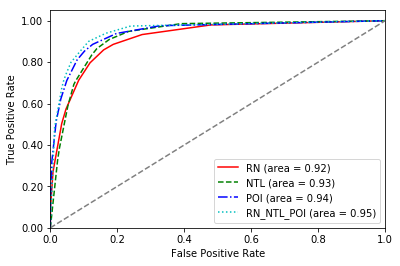

In [16]:
fig,ax = plt.subplots(1,1)
def plot_roc(paras):
    '''para_DT: the predicted result and parameter of decision tree.
    '''
    i = 0
    for key,value in paras.items():
        y_name = "Target"
        score_name = "Proba"
        label_name = value['Name']
        y = value[y_name]
        scores = value[score_name][:,1]
        colors = ['r','g','b','c'] ###
        linestyle = ['-','--','-.',':'] ###
        # scores = para_DT['0']["Log_Proba"][:,1]
        fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
        roc_auc = round(auc(fpr, tpr),2)
        ax.plot(fpr, tpr, label= '%s (area = %s)' % (label_name, roc_auc), color = colors[i], linestyle = linestyle[i])
        i += 1
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic of Urban Built Extraction')
#     plt.grid(True)
    y1 = np.linspace(0,1,6)
    y_label = ['%.2f' % i for i in y1]
    plt.yticks(y1,y_label)
    
    ax.legend(shadow=False,facecolor='w',loc=4)
    # plt.show()
    plt.savefig('plot/ROC.png', dpi=600, bbox_inches = 'tight')
plot_roc(para_DT)

# compute area

In [17]:
para_DT = pd.read_csv('data/pred_DT/para_DT.csv')

# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
area_real = 389.48
TN,TP,FN,FP = para_DT.TN, para_DT.TP, para_DT.FN, para_DT.FP
area_pred = (TP + FP)/(TP + FN)*area_real
area_error_rate = (abs(area_pred-area_real))/area_real*100

# area_Precision  = area_real*para_DT.Precision / 100
# area_Recall  = area_real*para_DT.Recall / 100

para_DT['Area_Real'] = area_real
para_DT['Area_Pred'] = area_pred
para_DT['Area_Error_Rate'] = area_error_rate
para_DT.columns

order_2 = ['Name', 'Area_Real', 'Area_Pred', 'Area_Error_Rate']
para_DT_2 =para_DT[order_2]
para_DT_2 = para_DT_2.round(2) # 所有数值为两位小数
# para_DT.loc[4] = ['Unit', '%', '%', '%', '%', '%', 'km\N{SUPERSCRIPT TWO}', 'km\N{SUPERSCRIPT TWO}', '%'] # 此步在保留小数之后

para_DT_2.to_csv('data/pred_DT/para_DT_area.csv',index = False)